# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, for inclusion of an image classifier in a smart phone app. To do this, it will make use of a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, there will be training of an image classifier to recognise different species of flowers. Conceptually, imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice, it is by training this classifier, which can then be exported for use in an application. [This dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories will be used. Examples are shown below. 

<center><img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px></center>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

The implementation is in Python.

First up is importing the packages that are needed. And as this notebook _(at the time of writing this)_ is being done in Google Colab, other settings need to be set.

In [0]:
# Google Colab does not come with Torch installed.
# Following snippet of code installs the relevant version

#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# Verify that GPU is enabled for this notebook
# Following should print: CUDA is available!  Training on GPU.
# 
# If it prints otherwise, then enable GPU: 
# Menu > Runtime > Change runtime type > Hardware accelerator > GPU

import torch
import numpy as np

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU.')
else:
    print('CUDA is available!  Training on GPU.')

CUDA is available!  Training on GPU.


In [3]:
# Pillow version of 5.3.0 is required
# Uninstall the older version first
!pip uninstall -y Pillow

# Install the new one
!pip install Pillow==5.3.0

# Import the new one
import PIL
print(PIL.PILLOW_VERSION)
# This should print 5.3.0. If it doesn't, then restart runtime:
# Menu > Runtime > Restart runtime...

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl


5.3.0


In [0]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json

## Load the data

`torchvision` is used to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). Data is [downloaded here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, there would be transformations applied such as random scaling, cropping, and flipping. This will help the network generalise leading to better performance. If a pre-trained network is used, it should be ensured that the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this, there is no need for any scaling or rotation transformations, but there is a need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets, there is a need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [5]:
# Download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# Define transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

# Mapping labels
class_to_idx = train_data.class_to_idx

224


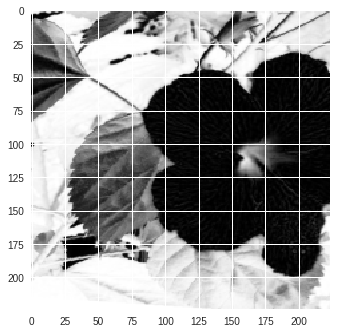

In [8]:
# Display transformed image
images, labels = next(iter(trainloader))
print(len(images[0,2]))
plt.imshow(images[0,0])

### Label mapping

There is loading in of mapping from category label to category name. They are in the `cat_to_name.json` file. It's a JSON object which can be read in with the [`json` module](https://docs.python.org/2/library/json.html). This gives a dictionary with mapping of the integer encoded categories to the actual names of the flowers.

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. This is by using one of the pretrained models from `torchvision.models` to get the image features. With this, it is possible to build and train a new feed-forward classifier using those features.

The process is:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (A starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training, it needs to be made sure to update only the weights of the feed-forward network. Validation accuracy above 70% should be reachable if it is built right. Different hyperparameters (learning rate, units in the classifier, epochs, etc) is usually tested to find the best model. 

In [10]:
# Load pre-trained model - Initial load
model = models.densenet161(pretrained=True)
model # Display pretrained model architecture 

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:01<00:00, 82277809.70it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [11]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Obtain input size for first layer by obtaining model size
classifier_input_size = model.classifier.in_features
print("Input size: ", classifier_input_size)
output_size = 102
hidden_layer = 512    
    
model.classifier = nn.Sequential(nn.Linear(classifier_input_size, hidden_layer),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(hidden_layer, output_size),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

Input size:  2208


In [12]:
# Build and train your network
epochs = 30
accuracy_best = -1 # Track change in accuracy. Initialise to -1 as arbitary value
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation Accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            
            # Save model if validation loss has decreased
            if accuracy/len(validloader) > accuracy_best:
              print(f"Accuracy improved ({accuracy_best:.6f} --> {accuracy/len(validloader):.6f}).  Saving model ...")
              torch.save(model.state_dict(), 'checkpoint.pt')
              accuracy_best = accuracy/len(validloader)
            
            model.train()
            model.class_to_idx = class_to_idx

Epoch 1/30.. Train loss: 4.813.. Validation loss: 4.473.. Validation Accuracy: 0.128
Accuracy improved (-1.000000 --> 0.127548).  Saving model ...
Epoch 1/30.. Train loss: 4.438.. Validation loss: 4.230.. Validation Accuracy: 0.101
Epoch 1/30.. Train loss: 4.190.. Validation loss: 4.038.. Validation Accuracy: 0.152
Accuracy improved (0.127548 --> 0.151827).  Saving model ...
Epoch 1/30.. Train loss: 4.062.. Validation loss: 3.739.. Validation Accuracy: 0.288
Accuracy improved (0.151827 --> 0.288029).  Saving model ...
Epoch 1/30.. Train loss: 3.806.. Validation loss: 3.489.. Validation Accuracy: 0.294
Accuracy improved (0.288029 --> 0.294231).  Saving model ...
Epoch 1/30.. Train loss: 3.474.. Validation loss: 3.155.. Validation Accuracy: 0.301
Accuracy improved (0.294231 --> 0.300769).  Saving model ...
Epoch 1/30.. Train loss: 3.136.. Validation loss: 2.880.. Validation Accuracy: 0.347
Accuracy improved (0.300769 --> 0.346779).  Saving model ...
Epoch 1/30.. Train loss: 2.936.. Valid

## Save the checkpoint

Now that the network is trained, the process is to save the model so it can loaded later for making predictions. Also, it's worthwile to save other properties such as the mapping of classes to indices which is obtained from one of the image datasets: `image_datasets['train'].class_to_idx`. This is attached to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

This will allow to completely rebuild the model later so it can be used for inference. Therefore, it needs to be insured to include any information needed in the checkpoint. For loading the model to keep training, it is needed to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. 

In [0]:
# Save the checkpoint

# Load the model with the lowest validation loss
model.load_state_dict(torch.load('checkpoint.pt'))

# Save num of epochs to the checkpoint
model.epochs = epochs

# Create checkpoints with additional parameters
checkpoint = {'input_size': [3, 224, 224],
              'batch_size': trainloader.batch_size,
              'output_size': 102,
              'state_dict': model.state_dict(),
              'optimizer_dict':optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
              'epoch': model.epochs}

torch.save(checkpoint, 'model_checkpoint.pt')

## Loading the checkpoint

At this point, it's good to write a function that can load a checkpoint and rebuild the model. That way, it is possible to come back to this project and keep working on it without having to retrain the network.

In [14]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
  model = models.densenet161(pretrained=False)
  
  model.classifier = nn.Sequential(nn.Linear(classifier_input_size, hidden_layer),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(hidden_layer, output_size),
                                   nn.LogSoftmax(dim=1))
  
  checkpoint = torch.load(filepath, map_location='cpu')
  model.load_state_dict(checkpoint['state_dict'], strict=False)
  
  return model

load_checkpoint('model_checkpoint.pt')

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

# Inference for classification

Now a function is written to use a trained network for inference. That is, pass an image into the network and predict the class of the flower in the image. This function called `predict` takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It looks like: 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First, it needs to handle processing the input image such that it can be used in the network. 

## Image Preprocessing

`PIL` is used to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function processes the images in the same manner used for training. 

First, it resizes the images where the shortest side is 256 pixels, keeping the aspect ratio. This is done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize) methods. Then, crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. The values need to be converted. It's easiest with a Numpy array, which is obtainable from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This is done by subtracting the means from each color channel, then dividing by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Therefore, there is a need to reorder the dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    # Resize images
    width, height = image.size
    
    if height > width:
        height = int(max(height * 256 / width, 1))
        width = int(256)
    else:
        width = int(max(width * 256 / height, 1))
        height = int(256)
        
    image = image.resize((width, height))
    
    # Crop center 224x224 portion of the image
    left = (image.width-224)/2
    upper = (image.height-224)/2
    right = left + 224
    lower = upper + 224
    image = image.crop((left, upper, right, lower))
    
    # Normalize
    image = np.array(image)/255
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean)/std
    
    # Reorder dimensions
    image = image.transpose((2, 0, 1))
    
    torch.from_numpy(image)
    
    return image
  
image = process_image(Image.open('flower_data/train/1/image_06734.jpg'))
print(image.shape)

(3, 224, 224)


To check the work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

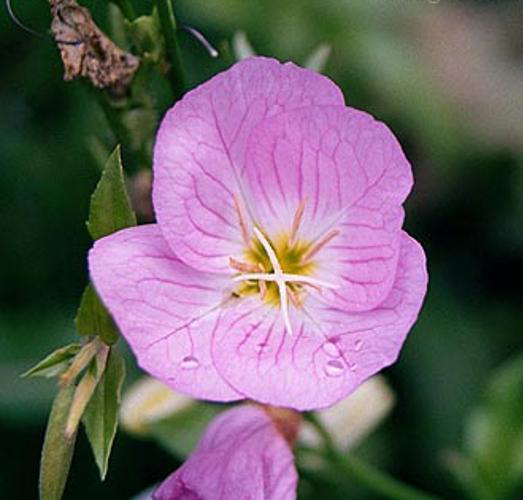

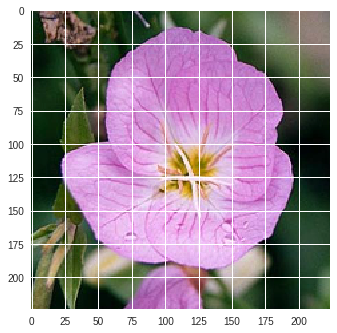

In [16]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Function output and original image displayed for comparison
imshow(torch.from_numpy(process_image(Image.open('flower_data/train/1/image_06734.jpg'))))
display(Image.open('flower_data/train/1/image_06734.jpg'))

## Class Prediction

Once the images are in the correct format, it's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. Therefore, calculation of the class probabilities is done then the $K$ largest values is found.

To get the top $K$ largest values in a tensor, [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk) is used. This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. Conversion occurs from these indices to the actual class labels using `class_to_idx` which is added to the model or from an `ImageFolder` used to load the data ([see here](#Save-the-checkpoint)). Finally, the dictionary is inverted so a mapping from index to class is obtained as well.

Again, this method takes a path to an image and a model checkpoint, then return the probabilities and classes. As such:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Code to predict the class from an image file
    
    # Set the model to evaluation mode
    model.eval()
    
    # Obtain image from image_path
    image = Image.open(image_path)
    
    # Process image
    image = process_image(image)
    
    # Numpy -> Tensor
    image = torch.from_numpy(image).type(torch.FloatTensor)
    
    # Unsqueeze returns a new tensor with a dimension of size one
    image = image.unsqueeze(0)
    
    # Send the model to CPU
    model.cpu()
    
    # Disabling gradient calculation
    with torch.no_grad():
        output = model.forward(image)
        top_prob, top_labels = torch.topk(output, topk)
        
        # Calculate the exponentials
        top_prob = top_prob.exp()
        
    class_to_idx_inv = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    
    for label in top_labels.numpy()[0]:
        mapped_classes.append(class_to_idx_inv[label])
        
    return top_prob.numpy()[0], mapped_classes
  
predict('flower_data/valid/1/image_06739.jpg', model)

(array([9.9742174e-01, 2.5692130e-03, 2.5383338e-06, 2.0368095e-06,
        1.3757947e-06], dtype=float32), ['1', '19', '33', '86', '69'])

## Sanity Checking

Now that a trained model for predictions is used, a sanity check is done to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Also, for visual unserstanding, `matplotlib` to plot the probabilities for the top 5 classes as a bar graph is used, along with the input image. It looks like this:

<center><img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px></center>

Conversion from the class integer encoding to actual flower names happens with the `cat_to_name.json` file (loaded earlier in the notebook). To show a PyTorch tensor as an image, it uses the `imshow` function defined above.

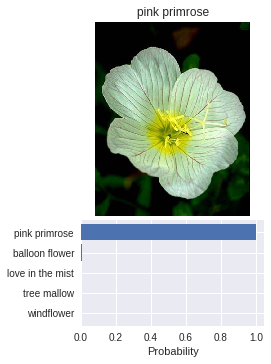

In [20]:
# Display an image along with the top 5 classes

def plot_prediction(image_path, model):
  # Values
  probabilities, classes = predict(image_path, model)
  max_index = np.argmax(probabilities)
  max_probability = probabilities[max_index]
  label = classes[max_index]

  # Initialise plot
  fig = plt.figure(figsize=(6,6))
  grid1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
  grid2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

  # Open image
  image = Image.open(image_path)
  
  # Label and image
  grid1.axis('off')
  grid1.set_title(cat_to_name[label])
  grid1.imshow(image)
  
  # Label and probabilities
  labels = []
  for cl in classes:
      labels.append(cat_to_name[cl])
  y_pos = np.arange(5)
  grid2.set_yticks(y_pos)
  grid2.set_yticklabels(labels)
  grid2.invert_yaxis()  # Probabilities top-to-bottom
  grid2.set_xlabel('Probability')
  grid2.barh(y_pos, probabilities, xerr=0, align='center')

  plt.show()

plot_prediction('flower_data/valid/1/image_06739.jpg', model)